In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('resources/2014_player_data_standardized.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'player_name', 'minutes_played', 'goals', 'npg',
       'assists', 'xG', 'xA', 'npxG', 'xG90', 'xA90', 'npxG90', 'position_x',
       'shots', 'key_passes', 'yellow_cards', 'red_cards', 'xGBuildup',
       'xGChain', 'market_value_in_eur', 'height_in_cm', 'age_in_months_2015',
       'points_per_game', 'team_rank',
       'player_performance_valuation_standardized'],
      dtype='object')

In [4]:
df.head()

,Unnamed: 0,player_name,minutes_played,goals,npg,assists,xG,xA,npxG,xG90,...,yellow_cards,red_cards,xGBuildup,xGChain,market_value_in_eur,height_in_cm,age_in_months_2015,points_per_game,team_rank,player_performance_valuation_standardized
0,1,David Silva,2682,12,12,7,9.096988,10.388413,9.096988,0.305268,...,8,0,16.633573,29.144278,50000.0,178.0,341.0,1.927632,13,11.325041
1,2,Graziano Pellè,3291,12,12,2,18.616503,4.481624,18.616503,0.509111,...,6,0,5.598169,24.785647,100000.0,194.0,356.0,1.447368,143,7.807678
2,3,Jakub Blaszczykowski,599,0,0,0,1.210137,0.883586,1.210137,0.181824,...,0,0,2.687145,4.451465,25000.0,176.0,351.0,1.959559,18,6.198375
3,4,Massimo Maccarone,2507,10,9,7,8.975993,7.552497,8.214694,0.322233,...,4,0,3.106277,14.702128,150000.0,180.0,426.0,1.157895,221,5.596764
4,5,Emanuele Giaccherini,292,0,0,0,0.334447,0.555395,0.334447,0.103083,...,2,0,0.334591,0.962826,75000.0,167.0,358.0,1.072368,107,5.115847


In [5]:
df = df.drop('player_name', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('team_rank', axis=1)
# df = df.drop('ties', axis=1)
# df = df.drop('current_value', axis=1)
# df = df.drop('highest_value', axis=1)
# df = df.drop('games_played', axis=1)
# df = df.drop('team', axis=1)
X = pd.get_dummies(df.drop('player_performance_valuation_standardized', axis=1), drop_first=True)
X = X.dropna()

y = df['player_performance_valuation_standardized']
y = y[X.index]


# Remove outliers from y using IQR method
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# # Filter out outliers
non_outliers = (y >= lower_bound) & (y <= upper_bound)
X = X[non_outliers]
y = y[non_outliers]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]  # New parameter for controlling tree splits
}


# Initialize the model
gbr_model = GradientBoostingRegressor(random_state=42)


grid_search_gbr = GridSearchCV(gbr_model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train, y_train)


best_gbr_params = grid_search_gbr.best_params_
best_gbr_model = grid_search_gbr.best_estimator_
gbr_predictions = best_gbr_model.predict(X_test)


gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_r2 = r2_score(y_test, gbr_predictions)
gbr_mae = mean_absolute_error(y_test, gbr_predictions)


gbr_errors = abs(gbr_predictions - y_test.values)
best_gbr_idx = gbr_errors.argmin()
worst_gbr_idx = gbr_errors.argmax()

best_gbr_prediction = gbr_predictions[best_gbr_idx]
worst_gbr_prediction = gbr_predictions[worst_gbr_idx]
best_gbr_actual = y_test.iloc[best_gbr_idx]
worst_gbr_actual = y_test.iloc[worst_gbr_idx]


print(f"Gradient Boosting Regression Performance (After Hyperparameter Tuning):")
print(f"Best Parameters: {best_gbr_params}")
print(f"R²: {gbr_r2:.10f}")
print(f"MSE: {gbr_mse:.10f}")
print(f"MAE: {gbr_mae:.10f}")
print(f"Best GBR Prediction: {best_gbr_prediction:.10f}, Actual: {best_gbr_actual:.10f}")
print(f"Worst GBR Prediction: {worst_gbr_prediction:.10f}, Actual: {worst_gbr_actual:.10f}")

Gradient Boosting Regression Performance (After Hyperparameter Tuning):
Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.8}
R²: 0.4870945749
MSE: 0.0301554387
MAE: 0.1176626372
Best GBR Prediction: -0.4333824928, Actual: -0.4353192191
Worst GBR Prediction: -0.1921876900, Actual: 0.5651330534


In [7]:
from sklearn.model_selection import cross_val_score
#Check if its overfitting, if CV scores are much lower than test R², this model is likely overfitting to the training set. (its not)
cv_scores = cross_val_score(best_gbr_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.2f}")

Cross-validated R² scores: [0.4334623  0.45012767 0.33832251 0.45002782 0.32875677]
Mean CV R²: 0.40


In [8]:
importances = best_gbr_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})


importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)


most_important_feature = importance_df_sorted.iloc[0]
print("Most Important Feature:")
print(most_important_feature)

Most Important Feature:
Feature       market_value_in_eur
Importance               0.338319
Name: 16, dtype: object


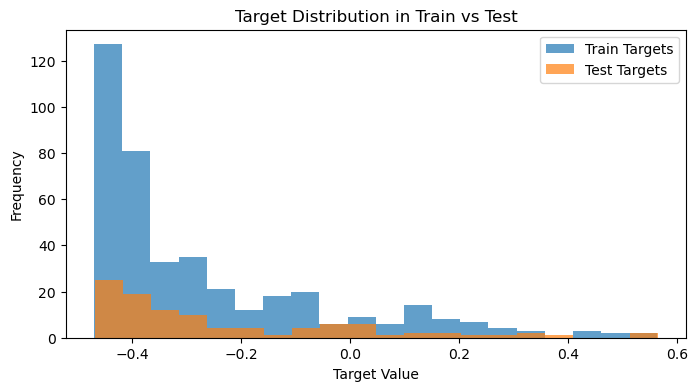

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(y_train, bins=20, alpha=0.7, label='Train Targets')
plt.hist(y_test, bins=20, alpha=0.7, label='Test Targets')
plt.legend()
plt.title('Target Distribution in Train vs Test')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()


In [10]:
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

# Display all feature importances
print("All Feature Importances:")
print(importance_df_sorted)

All Feature Importances:
                Feature  Importance
16  market_value_in_eur    0.338319
5                    xA    0.074897
1                 goals    0.068421
10                shots    0.065013
18   age_in_months_2015    0.050659
8                  xA90    0.047105
0        minutes_played    0.041183
17         height_in_cm    0.037265
15              xGChain    0.037085
6                  npxG    0.029922
9                npxG90    0.027294
4                    xG    0.025451
14            xGBuildup    0.024190
19      points_per_game    0.023151
11           key_passes    0.022413
7                  xG90    0.021412
12         yellow_cards    0.014346
3               assists    0.013182
2                   npg    0.008148
32         position_x_S    0.007403
13            red_cards    0.006327
31       position_x_M S    0.005862
26     position_x_F M S    0.002553
22     position_x_D M S    0.001582
23       position_x_D S    0.001566
24         position_x_F    0.001414
20 

In [11]:
pd.set_option('display.max_columns', None)
df.head()

,minutes_played,goals,npg,assists,xG,xA,npxG,xG90,xA90,npxG90,position_x,shots,key_passes,yellow_cards,red_cards,xGBuildup,xGChain,market_value_in_eur,height_in_cm,age_in_months_2015,points_per_game,player_performance_valuation_standardized
0,2682,12,12,7,9.096988,10.388413,9.096988,0.305268,0.348604,0.305268,M,66,92,8,0,16.633573,29.144278,50000.0,178.0,341.0,1.927632,11.325041
1,3291,12,12,2,18.616503,4.481624,18.616503,0.509111,0.122560,0.509111,F S,123,43,6,0,5.598169,24.785647,100000.0,194.0,356.0,1.447368,7.807678
2,599,0,0,0,1.210137,0.883586,1.210137,0.181824,0.132759,0.181824,M S,7,15,0,0,2.687145,4.451465,25000.0,176.0,351.0,1.959559,6.198375
3,2507,10,9,7,8.975993,7.552497,8.214694,0.322233,0.271131,0.294903,F S,87,50,4,0,3.106277,14.702128,150000.0,180.0,426.0,1.157895,5.596764
4,292,0,0,0,0.334447,0.555395,0.334447,0.103083,0.171183,0.103083,M S,8,10,2,0,0.334591,0.962826,75000.0,167.0,358.0,1.072368,5.115847


In [12]:
sample_input = pd.DataFrame([{
    'team': 'Manchester United',
    'position': 'Defender Centre-Back',
    'height': 189.0,
    'age': 32.0,
    'appearance': 104,
    'goals': 3,
    'assists': 0.0,
    'yellow cards': 0.009585,
    'second yellow cards': 0.0,
    'red cards': 1.0,
    'goals conceded': 1.217252,
    'clean sheets': 0.335463,
    'minutes played': 9390,
    'days_injured': 42,
    'games_injured': 5,
    'award': 13,
    'current_value': 15000000,
    'highest_value': 70000000,
    'position_encoded': 1,
    'winger': 0,
}])

In [13]:
sample_encoded = pd.get_dummies(sample_input)

# Reindex to match training feature columns
sample_encoded = sample_encoded.reindex(columns=X_train.columns, fill_value=0)

# Predict
predicted_win_rate = best_gbr_model.predict(sample_encoded)
print(f"Predicted Win Rate: {predicted_win_rate[0]:.2f}")

Predicted Win Rate: 0.07


In [14]:
print(y.value_counts())
print(y.describe())

player_performance_valuation_standardized
-0.440918    3
-0.055288    3
-0.303256    3
-0.385716    2
-0.386681    2
            ..
-0.250023    1
-0.248183    1
-0.247366    1
-0.247106    1
-0.267690    1
Name: count, Length: 482, dtype: int64
count    514.000000
mean      -0.263793
std        0.226670
min       -0.470193
25%       -0.428849
50%       -0.361288
75%       -0.152632
max        0.565133
Name: player_performance_valuation_standardized, dtype: float64


In [15]:
import numpy as np
print("Variance in y_test:", np.var(y_test))


Variance in y_test: 0.058793370555681124


In [16]:
print("Unique y_test values:", y_test.unique())
print("Unique predictions:", np.unique(gbr_predictions))


Unique y_test values: [-3.90568063e-01 -4.66214304e-01 -4.48400371e-01 -2.24457666e-01
 -4.66347321e-01 -1.62393629e-01 -3.03255832e-01 -4.68809187e-01
 -4.03351608e-01 -3.52171421e-01 -4.17850477e-01 -4.14040173e-01
 -3.85597883e-01 -5.42355340e-02  3.48213191e-01 -4.03335415e-01
 -2.44018128e-02  1.80586923e-01 -2.76253080e-01 -2.97810110e-01
 -3.24077463e-01 -3.06907548e-01 -3.80857501e-01 -3.06692076e-01
 -1.41638884e-01 -3.56221459e-01 -6.99010992e-03 -4.27313241e-01
 -4.10789625e-01 -4.02579603e-01 -3.49702013e-01 -4.05317871e-01
 -1.85467590e-01  3.82464925e-01  4.06148564e-03 -4.34344807e-01
 -4.64015646e-01 -3.31038124e-01  1.64639626e-04 -2.69932572e-01
 -4.35319219e-01  1.30868358e-02 -2.26795099e-01  7.62100938e-02
 -4.36794004e-01 -3.88818333e-01 -1.66788126e-02 -4.59500432e-01
 -3.99888930e-01 -4.60880166e-01 -5.87011669e-02 -3.42744833e-01
 -4.63087321e-01  3.91183343e-02 -4.54301814e-01  9.72285567e-03
  5.33755131e-01 -3.83651667e-01 -1.71332634e-01 -3.54627390e-01
 -2

In [17]:
average = y_test.mean()

In [18]:
average

np.float64(-0.23846121388015235)